In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

# Urbanisation

** ADD description

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [3]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr


In [4]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [33]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
platform_analysis = "LANDSAT_7"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2017-1-1'
baseline_end_date = '2017-12-1'

#set the analysis start and end of period
#analysis_start_date = '2017-1-1'
#analysis_end_date = '2017-12-1'

# If a geomedian is selected, it will take much longer to process

# options are "median" or "geomedian"
#mosaic_type = "geomedian" # change this to geomedian 

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#ai_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((179.4389622562436 -16.668794626017938,179.51758316688813 -16.668794626017938,179.51758316688813 -16.734562495004166,179.4389622562436 -16.734562495004166,179.4389622562436 -16.668794626017938))"
#aoi_wkt = "POLYGON((179.34386185341157 -16.511847130448928,179.73662308388032 -16.511847130448928,179.73662308388032 -16.83810084556268,179.34386185341157 -16.83810084556268,179.34386185341157 -16.511847130448928))"
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

## create AOI

In [34]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [35]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [36]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [37]:
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [38]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [39]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [40]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [41]:
print(lat_range)

(3868865.296636806, 3882539.0512192366)


In [42]:
print(lon_range)

(1962643.4711290102, 1978898.4636792026)


## Translate inputs and load data

In [43]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product

In [44]:
baseline_product, baseline_measurement = create_product_measurement(platform_base)
analysis_product, analysis_measurement = create_product_measurement(platform_analysis)

ValueError: too many values to unpack (expected 2)

In [45]:
baseline_product = create_product_measurement(platform_base)
analysis_product = create_product_measurement(platform_analysis)

In [46]:
#create resolution
resolution = (-res, res)

In [47]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [48]:
x_extents = (2050000.0, 2150000.0)
y_extents = (3999700.0, 4100300.0)

In [49]:
#lon_range = (2063266.0, 2105301.0)
#lat_range = (4017815.0, 4053752.0)

In [50]:
#lon_range = (2050000.0, 2150000.0)
#lat_range = (3999700.0, 4100300.0)

In [51]:
x_extents = (2033081.0, 2133081.0)
y_extents = (3999700.0, 4100300.0)

In [52]:
#x_extents = (2115000.0, 2160000.0)
#y_extents = (3995000.0, 4040000.0)

In [53]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

In [54]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    #'y': y_extents,
    #'x': x_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [55]:
baseline_ds = dc.load(
    #time = 2017,
    time = baseline_time_period,
    #measurements = baseline_measurement,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [56]:
analysis_ds = dc.load(
    time = analysis_time_period,
    measurements = analysis_measurement,
    product = analysis_product,
    platform = platform_analysis,
    crs = crs,
    **query
)

NameError: name 'analysis_measurement' is not defined

> #### Check if loads are valid

In [57]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [58]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [59]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 1, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2017-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    green    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [63]:
#baseline_ds.red.plot(col='time', cmap='Greens', col_wrap=3)


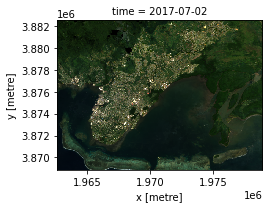

In [62]:
baseline_ds[['red','green','blue']].to_array().plot.imshow(
    x=baseline_ds.crs.dimensions[1],
    y=baseline_ds.crs.dimensions[0],
    col='time',
    #figsize=(20, 20),
    vmin=0,
    vmax=3000,
    col_wrap=4,
    #add_colorbar=False
)

In [64]:
baseline_ds_2 = baseline_ds.compute()

In [66]:
from datacube_utilities.createindices import NDVI, NDWI, NDBI

In [69]:
ndbi_base = NDBI(baseline_ds_2)  # Urbanization

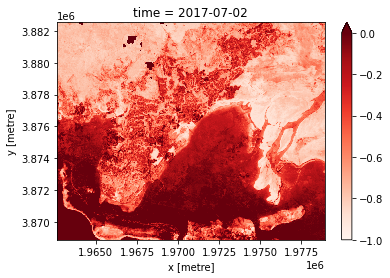

In [70]:
(ndbi_base).plot(cmap = "Reds", vmin = -1, vmax = 0)

In [33]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

NameError: name 'analysis_ds' is not defined

In [ ]:
print('broken')

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [ ]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [ ]:
baseline_clean_mask = look_up_clean(platform_base, baseline_ds)
analysis_clean_mask = look_up_clean(platform_analysis, analysis_ds)

In [ ]:
#baseline_ds = baseline_ds.where(baseline_clean_mask)
#analysis_ds = analysis_ds.where(analysis_clean_mask)

In [ ]:
xx_data_b = baseline_ds[allmeasurements]
xx_data_a = analysis_ds[allmeasurements]

In [ ]:

xx_clean_b = odc.algo.keep_good_only(xx_data_b, where=baseline_clean_mask)

In [ ]:
xx_clean_a = odc.algo.keep_good_only(xx_data_a, where=analysis_clean_mask)

In [ ]:
scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

In [ ]:
#scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
yy_a = xr_geomedian(xx_clean_a_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

>#### Mosaic
> Use clean masks in a time series composite

## Mask Water New

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = dask.delayed(wofs_classify)(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = dask.delayed(water_classes_base.rename({'wofs': 'water_classification'}))
               

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = dask.delayed(wofs_classify)(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = dask.delayed(water_classes_analysis.rename({'wofs': 'water_classification'}))
               

## mask water


In [36]:
water_composite_base = water_classes_base.water_classification.mean(dim='time')


In [37]:
water_composite_analysis = water_classes_analysis.water_classification.mean(dim='time')

In [38]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})

>## Plot a spectral index using the cloud-filtered mosaic

# Spectral Parameter Anomaly

In [39]:
def createparametercomposite(indices, ds):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['FC']:
        parameter_composite = frac_coverage_classify(ds, no_data = np.nan) 
    else:
        print('invalid indices')
    return parameter_composite

In [40]:
indices = 'FC'

In [41]:
parameter_baseline_composite = dask.delayed(createparametercomposite)(indices, baseline_composite)
parameter_analysis_composite = dask.delayed(createparametercomposite)(indices, analysis_composite)

## Apply water mask


In [42]:
frac_cov_baseline = parameter_baseline_composite.where(water_composite_base.values <= 0.4).where(parameter_baseline_composite !=-9999)

In [43]:
frac_cov_analysis = parameter_analysis_composite.where(water_composite_analysis.values <= 0.4).where(parameter_analysis_composite !=-9999)

In [44]:
#parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite
parameter_anomaly = frac_cov_analysis - frac_cov_baseline

In [45]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 26 s, sys: 7.31 s, total: 33.3 s
Wall time: 36.4 s


# Export Product

In [46]:
bs_output = parameter_anomaly_output.bs
pv_output = parameter_anomaly_output.pv
npv_output = parameter_anomaly_output.npv

In [47]:
write_geotiff_from_xr('land_change.tiff', parameter_anomaly_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

In [48]:
write_geotiff_from_xr('bs_change.tiff', bs_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('pv_change.tiff', pv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('npv_change.tiff', npv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')